In [317]:
import numpy as np
import category_encoders as ce
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import torch
#print(torch.__version__)
from torch.autograd import Variable
from torch import nn
import torch.nn.init
import torch.nn.functional as F
import torch.utils.data as Data
import torch.optim as optim

In [318]:
df = pd.read_excel('thermal-dataset.xlsx', sheet_name ='dataset')
df.head()

,Name,V,M,n,np,B,G,E,v,H,...,Formula,space group,k_BTE_DFT,k_BTE_DFT（1000 K）,k_AFLOW_AAPL,k_AFLOW_AGL,k_AFLOW_AGL (Poisson ratio σ=0.25),k_Mingo,k_EXP,k_EXP（1000 K）
0,66_C,11.41,24.022,2,2,431.7450,518.2490,1110.438653,0.071337,95.902307,...,C (diamond),Fd-3m,NaN,NaN,2270.00,419.90,169.10,NaN,2200/3000,NaN
1,20012_InSb,73.73,236.570,2,2,36.8242,14.5179,38.494849,0.325772,3.219550,...,InSb,F-43m,NaN,NaN,NaN,3.02,3.64,NaN,20/16.5,NaN
2,1190_ZnSe,47.34,144.350,2,2,56.3189,29.0179,74.293904,0.280139,6.603032,...,ZnSe,F-43m,NaN,NaN,NaN,5.44,7.46,NaN,19/33,NaN
3,682_NaF,24.74,41.988,2,2,52.4118,36.3275,88.528881,0.218483,10.653966,...,NaF,Fm-3m,NaN,NaN,21.11,4.67,4.52,NaN,16.5/18.4,NaN
4,16220_Si,40.97,56.170,2,2,90.0009,63.4097,154.050571,0.214724,15.043345,...,Si,Fd-3m,NaN,NaN,144.00,26.19,20.58,NaN,146/166,NaN


In [319]:
df.columns

Index(['Name', 'V', 'M', 'n', 'np', 'B', 'G', 'E', 'v', 'H', 'B'', 'G'', 'ρ',
       'vL', 'vS', 'va', 'Θe', 'γel', 'γes', 'γe', 'A', 'y-exp', 'y-theory',
       'Formula', 'space group', 'k_BTE_DFT', 'k_BTE_DFT（1000 K）',
       'k_AFLOW_AAPL', 'k_AFLOW_AGL', 'k_AFLOW_AGL (Poisson ratio σ=0.25)',
       'k_Mingo', 'k_EXP', 'k_EXP（1000 K）'],
      dtype='object')

In [320]:
df = df.loc[:, :'y-theory']
df.columns

Index(['Name', 'V', 'M', 'n', 'np', 'B', 'G', 'E', 'v', 'H', 'B'', 'G'', 'ρ',
       'vL', 'vS', 'va', 'Θe', 'γel', 'γes', 'γe', 'A', 'y-exp', 'y-theory'],
      dtype='object')

In [321]:
df.describe()

,V,M,n,np,B,G,E,v,H,B',...,vL,vS,va,Θe,γel,γes,γe,A,y-exp,y-theory
count,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,...,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,3.700000e+02,370.000000,370.000000
mean,145.503405,576.941738,6.810811,3.789189,111.257870,59.678087,147.105572,0.296581,10.521358,-6.982807,...,5.385817,2.928926,3.256445,263.253037,1.594866,1.119608,1.995672,9.121067e-05,44.079546,24.255426
std,132.334810,625.505406,4.818313,3.150066,82.433063,77.165080,170.936177,0.083493,14.299973,11.632497,...,2.784979,1.973751,2.152686,225.042124,2.868737,4.816583,3.987999,9.802296e-04,277.377084,49.038768
min,11.410000,8.010000,2.000000,2.000000,7.904080,0.406580,1.215183,0.000656,0.006197,-104.589000,...,1.559351,0.331246,0.379108,25.916963,-7.029521,-65.475244,0.414990,1.459528e-07,0.086000,0.026157
25%,53.210000,157.831500,3.000000,3.000000,47.720850,19.017575,49.639698,0.250683,3.580389,-8.717083,...,3.836785,1.889592,2.115443,144.201287,1.107011,0.624775,0.921418,9.899596e-07,3.887500,4.432038
50%,76.590000,287.557000,5.000000,3.000000,92.003700,44.813700,114.970283,0.303591,7.326539,-2.906780,...,4.836986,2.496888,2.782292,210.531759,1.379069,1.027563,1.199428,1.864054e-06,11.075000,12.781238
75%,219.020000,907.187000,12.000000,3.000000,160.493000,67.233975,175.339469,0.344524,11.691259,-1.296300,...,5.826099,3.203630,3.595112,281.975073,1.606329,1.373321,1.597086,3.706014e-06,23.082500,22.402090
max,995.000000,5168.290000,29.000000,29.000000,434.165000,523.852000,1120.785827,0.494396,106.084131,29.742400,...,18.019141,12.254442,13.361204,1755.800206,51.169090,47.244050,53.566903,1.670399e-02,5200.000000,547.103092


In [322]:
df.shape

(370, 23)

In [323]:
df.isna().sum()

Name        0
V           0
M           0
n           0
np          0
B           0
G           0
E           0
v           0
H           0
B'          0
G'          0
ρ           0
vL          0
vS          0
va          0
Θe          0
γel         0
γes         0
γe          0
A           0
y-exp       0
y-theory    0
dtype: int64

In [324]:
print(len(df.n.unique()))
print(len(df.np.unique()))

15
15


In [325]:
#Replacing "n"
X = df.loc[:, ['n']]
y = df['y-exp']
OHEncoder = ce.OneHotEncoder(cols = ['n'])
newCols = OHEncoder.fit_transform(X, y)
df = df.drop(['n'], axis = 1)
df = df.join(newCols)

#Replacing "np"
X = df.loc[:, ['np']]
y = df['y-exp']
OHEncoder = ce.OneHotEncoder(cols = ['np'])
newCols = OHEncoder.fit_transform(X, y)
df = df.drop(['np'], axis = 1)
df = df.join(newCols)

/home/sadman/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [326]:
df.columns, df.columns.shape

(Index(['Name', 'V', 'M', 'B', 'G', 'E', 'v', 'H', 'B'', 'G'', 'ρ', 'vL', 'vS',
        'va', 'Θe', 'γel', 'γes', 'γe', 'A', 'y-exp', 'y-theory', 'n_1', 'n_2',
        'n_3', 'n_4', 'n_5', 'n_6', 'n_7', 'n_8', 'n_9', 'n_10', 'n_11', 'n_12',
        'n_13', 'n_14', 'n_15', 'np_1', 'np_2', 'np_3', 'np_4', 'np_5', 'np_6',
        'np_7', 'np_8', 'np_9', 'np_10', 'np_11', 'np_12', 'np_13', 'np_14',
        'np_15'],
       dtype='object'),
 (51,))

In [327]:
y_theory = df['y-theory'].values
df = df.drop(columns=['y-theory'])
y_theory

array([5.47103092e+02, 4.34409393e+00, 8.83552653e+00, 1.76556363e+01,
       4.08157516e+01, 3.04336639e+01, 1.16520522e+01, 4.06207592e+01,
       6.14393581e+01, 1.46431122e+02, 1.30123539e+02, 4.01184072e+01,
       3.43295845e+02, 2.66374859e+01, 2.05159539e+01, 2.65594241e+02,
       2.22351199e+02, 2.31233787e+02, 1.92571258e+01, 1.79763713e+02,
       1.67790030e+02, 1.78481073e+02, 1.40004820e+02, 2.24286312e+01,
       1.71740875e+02, 1.64527923e+02, 1.51845435e+02, 1.67923922e+02,
       2.37071428e+01, 1.66205902e+02, 2.03897001e+02, 1.92243680e+02,
       2.49756459e+01, 1.72200844e+01, 1.87350480e+01, 1.16504218e+01,
       2.54374342e+01, 2.02139390e+01, 2.24774423e+01, 1.20080075e+02,
       2.47966820e+01, 8.79382272e+01, 3.49949208e+01, 1.09468699e+01,
       1.25784369e-01, 2.20510643e+01, 3.12421349e+00, 1.97465160e+01,
       1.90527938e+01, 1.91718068e+00, 2.39450091e+01, 9.73866313e+00,
       3.03845914e+01, 3.20414393e+01, 3.89541097e+01, 8.96149223e+00,
      

In [328]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
device

device(type='cpu')

In [329]:
# train, test = train_test_split(df, test_size=0.25, random_state=42, shuffle=True)
# test, val = train_test_split(test, test_size=0.4, random_state=42, shuffle=True)

In [330]:
# y_train = train['y-exp'].values
# excluded_columns = ["Name"]
# X_train = train.drop(excluded_columns, axis=1)

# y_test = test['y-exp'].values
# excluded_columns = ["Name"]
# X_test = test.drop(excluded_columns, axis=1)

# y_val = test['y-exp'].values
# excluded_columns = ["Name"]
# X_val = test.drop(excluded_columns, axis=1)

# X_train.shape[1], X_train.columns.values

In [331]:
# X_train.shape, y_test.shape, X_test.shape, y_test.shape

In [332]:
# scaler = RobustScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
# X_val = scaler.transform(X_val)

In [333]:
# y_train = torch.from_numpy(y_train)
# y_test = torch.from_numpy(y_test)
# y_val = torch.from_numpy(y_val)
# #y_train = y_train.view(y_train.shape[0], 1)
# y_test = y_test.view(y_test.shape[0], 1)
# y_val = y_val.view(y_val.shape[0], 1)
# y_train.shape, y_test.shape

In [334]:
# X_train = torch.from_numpy(X_train)
# X_test = torch.from_numpy(X_test)
# X_val = torch.from_numpy(X_val)
# X_train.shape, X_test.shape

In [335]:
# train_dataset = Data.TensorDataset(X_train, y_train)
# train_loader = Data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=1)
# len(train_loader)

In [336]:
# #X_train = Variable(X_train).to(device)
# X_test = Variable(X_test).to(device)
# X_val = Variable(X_val).to(device)
# #y_train = Variable(y_train).to(device)
# y_test = Variable(y_test).to(device)
# y_val = Variable(y_val).to(device)
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [337]:
class IRNet(nn.Module):
    def __init__(self):
        super(IRNet, self).__init__()
        
        self.linearXto1024 = nn.Sequential(
            nn.Linear(49, 1024, bias=True),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        
        self.linear1024to1024 = nn.Sequential(
            nn.Linear(1024, 1024, bias=True),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        
        self.linear1024to512 = nn.Sequential(
            nn.Linear(1024, 512, bias=True),
            nn.BatchNorm1d(512),
            nn.ReLU()
        )
        
        self.linear512to512 = nn.Sequential(
            nn.Linear(512, 512, bias=True),
            nn.BatchNorm1d(512),
            nn.ReLU()
        )
        
        self.linear512to256 = nn.Sequential(
            nn.Linear(512, 256, bias=True),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        
        self.linear256to256 = nn.Sequential(
            nn.Linear(256, 256, bias=True),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        
        self.linear256to128 = nn.Sequential(
            nn.Linear(256, 128, bias=True),
            nn.BatchNorm1d(128),
            nn.ReLU()
        )
        
        self.linear128to128 = nn.Sequential(
            nn.Linear(128, 128, bias=True),
            nn.BatchNorm1d(128),
            nn.ReLU()
        )
        
        self.linear128to64 = nn.Sequential(
            nn.Linear(128, 64, bias=True),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        
        self.linear64to64 = nn.Sequential(
            nn.Linear(64, 64, bias=True),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        
        self.linear64to32 = nn.Sequential(
            nn.Linear(64, 32, bias=True),
            nn.BatchNorm1d(32),
            nn.ReLU()
        )
        
        self.linear32to32 = nn.Sequential(
            nn.Linear(32, 32, bias=True),
            nn.BatchNorm1d(32),
            nn.ReLU()
        )
        
        self.linear32to1 = nn.Linear(32, 1, bias=True)
        
        self.projectionXto1024 = nn.Linear(49, 1024, bias=True)
        self.projection1024to512 = nn.Linear(1024, 512, bias=True)
        self.projection512to256 = nn.Linear(512, 256, bias=True)
        self.projection256to128 = nn.Linear(256, 128, bias=True)
        self.projection128to64 = nn.Linear(128, 64, bias=True)
        self.projection64to32 = nn.Linear(64, 32, bias=True)
        
    def forward(self, x):
        outPrev = x
        
        out = self.linearXto1024(x)
        out = torch.add(out, self.projectionXto1024(outPrev))
        outPrev = out
        
        out = self.linear1024to1024(out)
        out = torch.add(out, outPrev)
        outPrev = out
        out = self.linear1024to1024(out)
        out = torch.add(out, outPrev)
        outPrev = out
        out = self.linear1024to1024(out)
        out = torch.add(out, outPrev)
        outPrev = out
        
        out = self.linear1024to512(out)
        out = torch.add(out, self.projection1024to512(outPrev))
        outPrev = out
        
        out = self.linear512to512(out)
        out = torch.add(out, outPrev)
        outPrev = out
        out = self.linear512to512(out)
        out = torch.add(out, outPrev)
        outPrev = out
        
        out = self.linear512to256(out)
        out = torch.add(out, self.projection512to256(outPrev))
        outPrev = out
        
        out = self.linear256to256(out)
        out = torch.add(out, outPrev)
        outPrev = out
        out = self.linear256to256(out)
        out = torch.add(out, outPrev)
        outPrev = out
        
        out = self.linear256to128(out)
        out = torch.add(out, self.projection256to128(outPrev))
        outPrev = out
        
        out = self.linear128to128(out)
        out = torch.add(out, outPrev)
        outPrev = out
        out = self.linear128to128(out)
        out = torch.add(out, outPrev)
        outPrev = out
        
        out = self.linear128to64(out)
        out = torch.add(out, self.projection128to64(outPrev))
        outPrev = out
        
        out = self.linear64to64(out)
        out = torch.add(out, outPrev)
        outPrev = out
        
        out = self.linear64to32(out)
        out = torch.add(out, self.projection64to32(outPrev))
        
        out = self.linear32to1(out)
        
        return out
    
#irnet = IRNet().to(device)

In [338]:
# for name, param in irnet.state_dict().items():
#     print(name, param.size())

In [339]:
num_epochs = 300
learning_rate = 0.001
#criterion = nn.L1Loss()
criterion = nn.MSELoss()
#optimizer = torch.optim.Adam(irnet.parameters(), lr=learning_rate)

In [340]:
# losses_train = []
# losses_val = []
# epochs = []
# minLoss = 100.0
# minOutput = torch.Tensor(X_train.shape[0], 1)

# for epoch in range(num_epochs):
#     optimizer.zero_grad()
#     outputs = irnet(X_train.float())
#     val_outputs = irnet(X_val.float())
#     #print(type(outputs), outputs.shape)
#     #print(outputs)
#     #print(final_output)
#     #print(outputs.shape)
#     #print(ytor.shape)
#     loss = criterion(outputs, y_train.float())
#     if loss.data < minLoss:
#         minLoss = loss.data
#         minOutput = outputs
#     loss.backward()
#     optimizer.step()

#     print('Epoch [%d/%d], Loss: %.4f'
#          %(epoch+1, num_epochs, loss.data))
#     epochs.append(epoch)
#     losses_train.append(loss)
#     losses_val.append(criterion(val_outputs, y_val.float()))
# #print(minLoss.cpu().detach().numpy())

In [341]:
# for i in range(len(losses_train)):
#     losses_train[i] = losses_train[i].cpu().detach().numpy()
#     losses_val[i] = losses_val[i].cpu().detach().numpy()
# #     losses_train[i] = losses_train[i]
# #     losses_val[i] = losses_val[i]
# plt.plot(epochs, losses_train)
# plt.plot(epochs, losses_val)
# plt.show()

In [342]:
# final_output_train = irnet(X_train.float())

In [343]:
# print('Results on training set using 17 layer IRNet after %d iterations:\n------------------------------'%(num_epochs))
# print('r2 score: ', r2_score(y_train.cpu().detach().numpy(), final_output_train.cpu().detach().numpy()))
# print('Mean Absolute Error:', criterion(final_output_train, y_train.float()).cpu().detach().numpy())
# print('Mean Squared Error: ', mean_squared_error(y_train.cpu().detach().numpy(), final_output_train.cpu().detach().numpy()))
# print('Root mean squared error: ', np.sqrt(mean_squared_error(y_train.cpu().detach().numpy(), final_output_train.cpu().detach().numpy())))

In [344]:
# final_output_test = irnet(X_test.float())

In [345]:
# print('Results on test set using 17 layer IRNet after %d iterations:\n------------------------------'%(num_epochs))
# print('Mean Absolute Error:', criterion(final_output_test, y_test.float()).cpu().detach().numpy())
# print('r2 score: ', r2_score(y_test.cpu().detach().numpy(), final_output_test.cpu().detach().numpy()))
# print('Mean Squared Error: ', mean_squared_error(y_test.cpu().detach().numpy(), final_output_test.cpu().detach().numpy()))
# print('Root mean squared error: ', np.sqrt(mean_squared_error(y_test.cpu().detach().numpy(), final_output_test.cpu().detach().numpy())))

In [346]:
losses_train = []
losses_val = []
epochs = np.arange(1, num_epochs + 1)
final_output_test = torch.Tensor(55, 1)
cv_error = []
for r in range(3):
    irnet = IRNet().to(device)
    optimizer = torch.optim.Adam(irnet.parameters(), lr=learning_rate)
    
    minLoss = 1000000000000.0
    
    train, test = train_test_split(df, test_size=0.25, random_state=r*2, shuffle=True)
    test, val = train_test_split(test, test_size=0.4, random_state=r*2, shuffle=True)
    
    y_train = train['y-exp'].values
    excluded_columns = ["Name"]
    X_train = train.drop(excluded_columns, axis=1)

    y_test = test['y-exp'].values
    excluded_columns = ["Name"]
    X_test = test.drop(excluded_columns, axis=1)

    y_val = test['y-exp'].values
    excluded_columns = ["Name"]
    X_val = test.drop(excluded_columns, axis=1)
    
    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_val = scaler.transform(X_val)
    
    y_train = torch.from_numpy(y_train)
    y_test = torch.from_numpy(y_test)
    y_val = torch.from_numpy(y_val)
    #y_train = y_train.view(y_train.shape[0], 1)
    y_test = y_test.view(y_test.shape[0], 1)
    y_val = y_val.view(y_val.shape[0], 1)
    
    X_train = torch.from_numpy(X_train)
    X_test = torch.from_numpy(X_test)
    X_val = torch.from_numpy(X_val)
    
    train_dataset = Data.TensorDataset(X_train, y_train)
    train_loader = Data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=1)
    
    #X_train = Variable(X_train).to(device)
    X_test = Variable(X_test).to(device)
    X_val = Variable(X_val).to(device)
    #y_train = Variable(y_train).to(device)
    y_test = Variable(y_test).to(device)
    y_val = Variable(y_val).to(device)
    
    print(f'CV-{r + 1}:\n----------------')
    
    for epoch in range(num_epochs):
        for i, (batch_X, batch_y) in enumerate(train_loader):
            #print(batch_X, batch_y)
            optimizer.zero_grad()

            Xtor = Variable(batch_X).to(device)
            ytor = Variable(batch_y.view(batch_y.shape[0], 1)).to(device)
            #print(Xtor.shape, ytor.shape)

            outputs = irnet(Xtor.float())
            val_outputs = irnet(X_val.float())

            loss = criterion(outputs, ytor.float())
            val_loss = criterion(val_outputs, y_val.float())
            loss.backward()
            optimizer.step()

        print('Epoch [%d/%d], Train loss: %.4f, Validation loss: %.4f'
             %(epoch+1, num_epochs, loss.data, val_loss.data))
        
        if r == 0:
            losses_train.append(loss)
            losses_val.append(val_loss)

        if val_loss.data < minLoss:
            minLoss = val_loss.data
            #print('%.4f'%(minLoss))
            final_output_test = irnet(X_test.float())

    print('lowest validation error achieved : %.4f'%(minLoss))
    test_mse = mean_squared_error(y_test.cpu().detach().numpy(), final_output_test.cpu().detach().numpy())
    cv_error.append(test_mse)
    print('test error: ', test_mse)
    print('\n')

CV-1:
----------------
Epoch [1/300], Train loss: 2309.8411, Validation loss: 8104.2109
Epoch [2/300], Train loss: 970.8712, Validation loss: 650.1130
Epoch [3/300], Train loss: 4762.8071, Validation loss: 8063.4609
Epoch [4/300], Train loss: 614.3819, Validation loss: 12687.9033
Epoch [5/300], Train loss: 12906.9805, Validation loss: 13819.0811
Epoch [6/300], Train loss: 2273.4360, Validation loss: 12828.2305
Epoch [7/300], Train loss: 11379.9082, Validation loss: 11880.7207
Epoch [8/300], Train loss: 4634.9146, Validation loss: 11514.0889
Epoch [9/300], Train loss: 3016.0225, Validation loss: 11081.1260
Epoch [10/300], Train loss: 1188.3755, Validation loss: 10245.0986
Epoch [11/300], Train loss: 364.0681, Validation loss: 8853.2832
Epoch [12/300], Train loss: 394.3803, Validation loss: 6102.2002
Epoch [13/300], Train loss: 1274.9895, Validation loss: 1621.0010
Epoch [14/300], Train loss: 8878.3037, Validation loss: 6971.1152
Epoch [15/300], Train loss: 81649.2344, Validation loss: 4

Epoch [127/300], Train loss: 91.5433, Validation loss: 259.6175
Epoch [128/300], Train loss: 45.3403, Validation loss: 557.0303
Epoch [129/300], Train loss: 27.1581, Validation loss: 304.2428
Epoch [130/300], Train loss: 300.5128, Validation loss: 183.9917
Epoch [131/300], Train loss: 124.9071, Validation loss: 149.5026
Epoch [132/300], Train loss: 97.9590, Validation loss: 240.6421
Epoch [133/300], Train loss: 2320.3003, Validation loss: 390.3127
Epoch [134/300], Train loss: 27.9599, Validation loss: 170.8276
Epoch [135/300], Train loss: 154.5733, Validation loss: 239.9245
Epoch [136/300], Train loss: 102.4067, Validation loss: 401.7936
Epoch [137/300], Train loss: 161.9100, Validation loss: 244.0932
Epoch [138/300], Train loss: 16.5138, Validation loss: 191.7518
Epoch [139/300], Train loss: 626.8087, Validation loss: 164.8553
Epoch [140/300], Train loss: 114.1499, Validation loss: 283.4622
Epoch [141/300], Train loss: 2470.1902, Validation loss: 369.3896
Epoch [142/300], Train loss: 

Epoch [255/300], Train loss: 32.3453, Validation loss: 124.0834
Epoch [256/300], Train loss: 72.6008, Validation loss: 780.5040
Epoch [257/300], Train loss: 53.9119, Validation loss: 236.2103
Epoch [258/300], Train loss: 53.5920, Validation loss: 153.3633
Epoch [259/300], Train loss: 15412.7676, Validation loss: 136.0977
Epoch [260/300], Train loss: 115.2659, Validation loss: 1432.8756
Epoch [261/300], Train loss: 22.1547, Validation loss: 177.4433
Epoch [262/300], Train loss: 95.2331, Validation loss: 261.2339
Epoch [263/300], Train loss: 91.8228, Validation loss: 783.5559
Epoch [264/300], Train loss: 41.0724, Validation loss: 558.7222
Epoch [265/300], Train loss: 4671.0298, Validation loss: 206.6319
Epoch [266/300], Train loss: 100.7942, Validation loss: 668.3789
Epoch [267/300], Train loss: 53.6434, Validation loss: 359.7786
Epoch [268/300], Train loss: 47.1360, Validation loss: 195.7070
Epoch [269/300], Train loss: 27.7066, Validation loss: 351.5658
Epoch [270/300], Train loss: 16.

Epoch [81/300], Train loss: 145.9429, Validation loss: 58.7848
Epoch [82/300], Train loss: 106.3717, Validation loss: 32.7370
Epoch [83/300], Train loss: 158.0344, Validation loss: 82.1772
Epoch [84/300], Train loss: 7294.0640, Validation loss: 84.5913
Epoch [85/300], Train loss: 1317.7729, Validation loss: 21.1719
Epoch [86/300], Train loss: 228.2665, Validation loss: 32.3131
Epoch [87/300], Train loss: 43949.3906, Validation loss: 59.2698
Epoch [88/300], Train loss: 7317.5952, Validation loss: 58.4323
Epoch [89/300], Train loss: 29.6535, Validation loss: 89.0562
Epoch [90/300], Train loss: 110687.5391, Validation loss: 194.3358
Epoch [91/300], Train loss: 7493.5967, Validation loss: 770.6823
Epoch [92/300], Train loss: 125.9976, Validation loss: 187.9552
Epoch [93/300], Train loss: 63531.5703, Validation loss: 219.9807
Epoch [94/300], Train loss: 175.7048, Validation loss: 100.6188
Epoch [95/300], Train loss: 63.6572, Validation loss: 61.3611
Epoch [96/300], Train loss: 31.1173, Vali

Epoch [210/300], Train loss: 140.9042, Validation loss: 34.7817
Epoch [211/300], Train loss: 168.9182, Validation loss: 16.7787
Epoch [212/300], Train loss: 7.4158, Validation loss: 13.0677
Epoch [213/300], Train loss: 69.1903, Validation loss: 7.9925
Epoch [214/300], Train loss: 4.6753, Validation loss: 7.4068
Epoch [215/300], Train loss: 244.2329, Validation loss: 5.8324
Epoch [216/300], Train loss: 52.7212, Validation loss: 5.7102
Epoch [217/300], Train loss: 48.3909, Validation loss: 4.7904
Epoch [218/300], Train loss: 16.9241, Validation loss: 6.2846
Epoch [219/300], Train loss: 12.3179, Validation loss: 9.8961
Epoch [220/300], Train loss: 9.7051, Validation loss: 10.3496
Epoch [221/300], Train loss: 17.0234, Validation loss: 10.7501
Epoch [222/300], Train loss: 22.6309, Validation loss: 6.9399
Epoch [223/300], Train loss: 4.9160, Validation loss: 5.9217
Epoch [224/300], Train loss: 12.9708, Validation loss: 12.5576
Epoch [225/300], Train loss: 55.4032, Validation loss: 13.2838
Ep

Epoch [36/300], Train loss: 338.5067, Validation loss: 10940.5576
Epoch [37/300], Train loss: 125.8683, Validation loss: 14406.9697
Epoch [38/300], Train loss: 68.4023, Validation loss: 10288.3223
Epoch [39/300], Train loss: 172.2272, Validation loss: 1829.0637
Epoch [40/300], Train loss: 885.8872, Validation loss: 3081.2239
Epoch [41/300], Train loss: 3347.7300, Validation loss: 6874.7305
Epoch [42/300], Train loss: 1024.1449, Validation loss: 5317.7769
Epoch [43/300], Train loss: 1012.0021, Validation loss: 3614.3525
Epoch [44/300], Train loss: 1210.3983, Validation loss: 2819.5557
Epoch [45/300], Train loss: 12796.0684, Validation loss: 2204.7637
Epoch [46/300], Train loss: 1015.3221, Validation loss: 2874.5295
Epoch [47/300], Train loss: 3630.8032, Validation loss: 2661.8306
Epoch [48/300], Train loss: 38.6195, Validation loss: 2935.1411
Epoch [49/300], Train loss: 6395.6504, Validation loss: 2823.0994
Epoch [50/300], Train loss: 5369.0898, Validation loss: 1530.3193
Epoch [51/300]

Epoch [163/300], Train loss: 74.9720, Validation loss: 595.7872
Epoch [164/300], Train loss: 145.2076, Validation loss: 711.3098
Epoch [165/300], Train loss: 284.3123, Validation loss: 693.2288
Epoch [166/300], Train loss: 138.3975, Validation loss: 436.8673
Epoch [167/300], Train loss: 292.9124, Validation loss: 606.6089
Epoch [168/300], Train loss: 396.0034, Validation loss: 624.3257
Epoch [169/300], Train loss: 22.5851, Validation loss: 574.1160
Epoch [170/300], Train loss: 7658.6055, Validation loss: 664.2303
Epoch [171/300], Train loss: 136.3677, Validation loss: 415.3444
Epoch [172/300], Train loss: 80.4987, Validation loss: 437.4364
Epoch [173/300], Train loss: 163.0217, Validation loss: 518.5482
Epoch [174/300], Train loss: 1817.1843, Validation loss: 414.2203
Epoch [175/300], Train loss: 312.7479, Validation loss: 461.3197
Epoch [176/300], Train loss: 10.2742, Validation loss: 388.1077
Epoch [177/300], Train loss: 50.3665, Validation loss: 420.9211
Epoch [178/300], Train loss:

Epoch [290/300], Train loss: 87.4022, Validation loss: 3601.7212
Epoch [291/300], Train loss: 1311.7592, Validation loss: 3751.1069
Epoch [292/300], Train loss: 173.5644, Validation loss: 9315.7979
Epoch [293/300], Train loss: 390.3502, Validation loss: 12847.2041
Epoch [294/300], Train loss: 394.7887, Validation loss: 13538.6055
Epoch [295/300], Train loss: 3369.5859, Validation loss: 6101.4111
Epoch [296/300], Train loss: 288.0942, Validation loss: 1687.7939
Epoch [297/300], Train loss: 561.7949, Validation loss: 2935.0803
Epoch [298/300], Train loss: 794.8951, Validation loss: 1370.9696
Epoch [299/300], Train loss: 1582.4408, Validation loss: 4757.5024
Epoch [300/300], Train loss: 118.4967, Validation loss: 937.6154
lowest validation error achieved : 197.4027
test error:  202.6339721351057




In [347]:
print("CV error : ", np.mean(cv_error))

CV error :  97.62043552282408


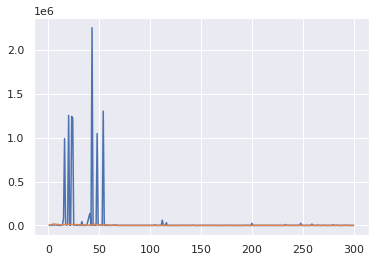

In [348]:
for i in range(len(losses_train)):
    losses_train[i] = losses_train[i].cpu().detach().numpy()
    losses_val[i] = losses_val[i].cpu().detach().numpy()
#     losses_train[i] = losses_train[i]
#     losses_val[i] = losses_val[i]
plt.plot(epochs, losses_train)
plt.plot(epochs, losses_val)
plt.show()

In [349]:
# print('Results on test set after %d iterations:\n------------------------------------------'%(num_epochs))
# #print('Mean Absolute Error:', criterion(final_output_test, y_test.float()).cpu().detach().numpy())
# #print('r2 score: ', r2_score(y_test.cpu().detach().numpy(), final_output_test.cpu().detach().numpy()))
# print('Mean Squared Error: ', mean_squared_error(y_test.cpu().detach().numpy(), final_output_test.cpu().detach().numpy()))
# #print('Root mean squared error: ', np.sqrt(mean_squared_error(y_test.cpu().detach().numpy(), final_output_test.cpu().detach().numpy())))

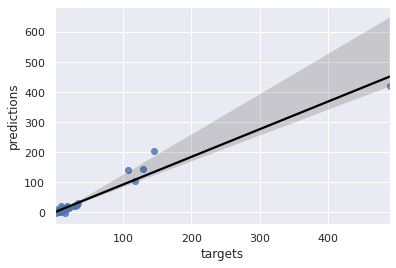

In [350]:
fig = plt.figure()
sns.set_theme(color_codes=True)
ax = sns.regplot(x=y_test.cpu().detach().numpy(), y=final_output_test.cpu().detach().numpy(), line_kws={"color": "black"})
plt.xlabel('targets')
plt.ylabel('predictions')
plt.show()

In [351]:
# losses_train = []
# losses_val = []
# epochs = []
# minLoss = 1000000000000.0
# final_output_test = torch.Tensor(X_test.shape[0], 1)

# for epoch in range(num_epochs):
#     for i, (batch_X, batch_y) in enumerate(train_loader):
#         #print(batch_X, batch_y)
#         optimizer.zero_grad()
        
#         Xtor = Variable(batch_X).to(device)
#         ytor = Variable(batch_y.view(batch_y.shape[0], 1)).to(device)
#         #print(Xtor.shape, ytor.shape)
        
#         outputs = irnet(Xtor.float())
#         val_outputs = irnet(X_val.float())
        
#         loss = criterion(outputs, ytor.float())
#         val_loss = criterion(val_outputs, y_val.float())
#         loss.backward()
#         optimizer.step()

#     print('Epoch [%d/%d], Train loss: %.4f, Validation loss: %.4f'
#          %(epoch+1, num_epochs, loss.data, val_loss.data))
#     epochs.append(epoch)
#     losses_train.append(loss)
#     losses_val.append(val_loss)
    
#     if val_loss.data < minLoss:
#         minLoss = val_loss.data
#         #print('%.4f'%(minLoss))
#         final_output_test = irnet(X_test.float())

# print('lowest validation error achieved : %.4f'%(minLoss))